## Import all required tools

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

import matplotlib.pyplot as plt

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import add_tech
from message_ix.tools.add_dac import get_report
from message_ix.tools.add_dac import get_values

%matplotlib inline



<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [2]:
# SSPs and scenarios lists
ssps = ["SSP1","SSP2","SSP3","SSP4","SSP5"]
ssps = ["SSP1","SSP2","SSP5"]
# Parameters for CO2 injection rate scenarios
co2rates = {
    "co2rate1": 0.2,
    "co2rate2": 0.4,
    "co2rate3": 0.6,
    "co2rate4": 0.8,
    "co2rate5": 1.0,
        }
max_rate = 20000

# Parameters for DAC market penetration rate scenarios
mpens = {
    "mpen1": 0.050,
    "mpen2": 0.075,
    "mpen3": 0.100,
    "mpen4": 0.125,
    "mpen5": 0.150,
        }

# Parameters for CO2 storage availability scenarios
stors = {
    "stor1": 0.2,
    "stor2": 0.4,
    "stor3": 0.6,
    "stor4": 0.8,
    "stor5": 1.0,
        }

maxfco2storshares = {
    "maxfco2storshare1": 1.00, # max
    "maxfco2storshare2": 0.80, # max
    "maxfco2storshare3": 0.60, # max
    "maxfco2storshare4": 0.40, # max
    "maxfco2storshare5": 0.20, # max
}

minfco2storshares = {
    "minfco2storshare1": 0.10, # min
    "minfco2storshare2": 0.20, # min
    "minfco2storshare3": 0.30, # min
    "minfco2storshare4": 0.40, # min
    "minfco2storshare5": 0.50, # min
}

daccosts ={
    "daccost1":[1.00,0.97,0.96,0.94,0.93,0.92,0.91,0.91,0.90,0.90,0.90,0.90,0.90],
    "daccost2":[1.00,0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
    "daccost3":[1.00,0.87,0.79,0.70,0.64,0.59,0.56,0.54,0.51,0.51,0.51,0.50,0.50],
    "daccost4":[1.00,0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
    "daccost5":[1.00,0.77,0.61,0.46,0.36,0.27,0.22,0.16,0.13,0.11,0.11,0.10,0.10],
}

dacenergies ={
    "dacener1":[1.00,0.97,0.96,0.94,0.93,0.92,0.91,0.91,0.90,0.90,0.90,0.90,0.90],
    "dacener2":[1.00,0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
    "dacener3":[1.00,0.87,0.79,0.70,0.64,0.59,0.56,0.54,0.51,0.51,0.51,0.50,0.50],
    "dacener4":[1.00,0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
    "dacener5":[1.00,0.77,0.61,0.46,0.36,0.27,0.22,0.16,0.13,0.11,0.11,0.10,0.10],
}

scenariotec = ['dac_lt','dac_ht']
parameters = {
#    "co2rates":co2rates, 
#    "mpens":mpens, 
#    "stors":stors, 
#    "maxfco2storshares":maxfco2storshares, 
    "minfco2storshares":minfco2storshares, 
    "daccosts":daccosts,
    "dacenergies":dacenergies
}

In [3]:
list(parameters)

['minfco2storshares', 'daccosts', 'dacenergies']

In [4]:
colors = {"SSP1":"tab:red","SSP2":"tab:orange","SSP3":"tab:green","SSP4":"tab:blue","SSP5":"tab:purple",}
lines = ["-","--","-.",":",(0, (3, 1, 1, 1, 1, 1))]


# Removal by DACCS

# Removal by CCS

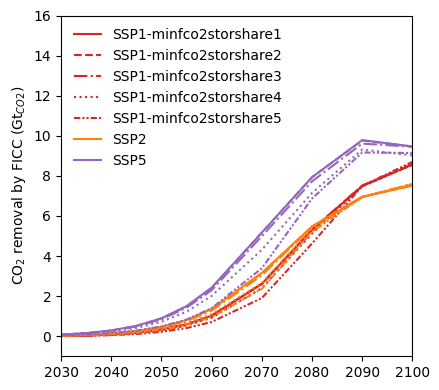

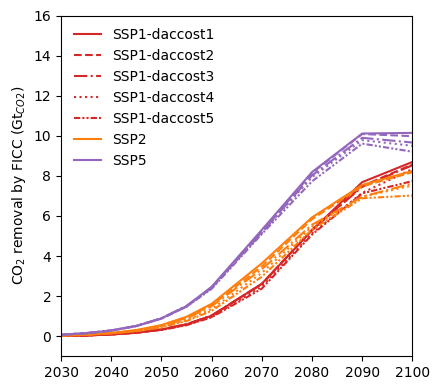

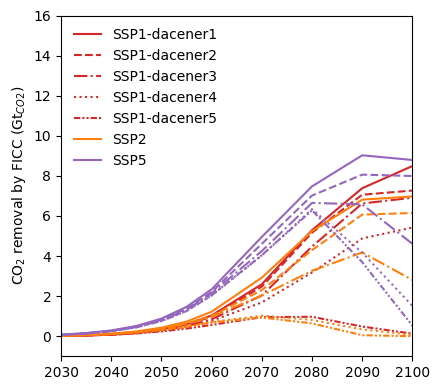

In [5]:
terms = ["long-term","short-term"]
terms = ["long-term"]

for par in list(parameters):
    mp = ixmp.Platform()

    if par == "mpens":
        scenarios = {f"SSP_dev_{ssp}_v0.1_dac": 
                 {f"1000f_v0.13_dac-co2split_{parsc}": [] for parsc in parameters[par].keys()} 
                 for ssp in ssps
                }
    else:
        scenarios = {f"SSP_dev_{ssp}_v0.1_dac": 
                 {f"1000f_v0.13_dac-co2split_mpen3_{parsc}": [] for parsc in parameters[par].keys()} 
                 for ssp in ssps
                }

    for k,v in scenarios.items():
        for k1,v1 in v.items():
            scen = message_ix.Scenario(mp, model=k, scenario=k1)
            ccsrem = (scen.var("ACT",{"technology":"co2_tr_sd","mode":"M1"})
                   .set_index(["node_loc","technology","year_vtg","year_act","mode","time"])
                   .droplevel(["mode","time"])).mul(3.67).div(1000)
            ccsrem = ccsrem.groupby("year_act").sum()["lvl"]
            scenarios[k][k1] = ccsrem
    
    for term in terms:
        plt.figure(figsize=(4.5,4))
        for ssp in ssps:
            for p in range(len(parameters[par].keys())):
                model = f"SSP_dev_{ssp}_v0.1_dac"
                if par == "mpens":
                    scenario = f"1000f_v0.13_dac-co2split_{list(parameters[par].keys())[p]}"
                else:
                    scenario = f"1000f_v0.13_dac-co2split_mpen3_{list(parameters[par].keys())[p]}"

                if ssp == "SSP1":
                    kwargs = {"label": f"{ssp}-{list(parameters[par].keys())[p]}"}
                elif ssp != "SSP1" and p == 0:
                    kwargs = {"label": f"{ssp}"}
                else:
                    kwargs = {}
                
                plt.plot(scenarios[model][scenario], ls=lines[p], c=colors[ssp], **kwargs)
        
        if term == "long-term":
            plt.xlim(2030,2100)
            plt.xticks(range(2030,2110,10))
            plt.ylim(-1,16)
            plt.yticks(range(0,18,2))
        else:
            plt.xlim(2030,2070)
            plt.xticks(range(2030,2080,10))
            plt.ylim(-1,16)
            plt.yticks(range(0,18,2))
        
        plt.ylabel("CO$_2$ removal by FICC (Gt$_{CO2}$)")
        plt.legend(frameon=False)
        plt.tight_layout()
        plt.savefig(f"{term}_ficc-removal_{par}-scenario.jpeg",dpi=300)
        plt.show()
    
    mp.close_db()

# CO2 Storage SSPs